In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Set logging level to INFO
logging.basicConfig(level=logging.DEBUG)

In [4]:
class Message:
    '''Class to keep sender, timestamp, public (To/Cc) and hidden (Bcc) recipients of a message
    
    Must map the Message class fields in parseMaildir.py for deserialization purposes
    '''
    def __init__(self, From, mtime, To, Cc, Bcc):
        self.From = From
        self.mtime = mtime
        self.To = To
        self.Cc = Cc
        self.Bcc = Bcc

In [5]:
# Parse the pickle files generated by parseMaildir.py
parsed_logs_folder = 'Enron/parsing/'
social_graph = pickle.load(open(parsed_logs_folder + "social.pkl", "rb"))
log = pickle.load(open(parsed_logs_folder + "replay_log.pkl", "rb"))

enc_status = {"plaintext": 0, "stale": 1, "encrypted": 2}
email_status = {"stat_autocrypt": [], "stat_pub_claimchain": [], "stat_priv_claimchain": [], "dyn_autocrypt": [], "dyn_pub_claimchain": [], "dyn_priv_claimchain": []}

In [6]:
def make_global_graph(log):
    '''Construct a global social graph using the log of all emails'''
    global_graph = {}
    global_userset = set()
    
    for email in log:
        if email.From not in global_userset:
            global_userset.add(email.From)
            global_graph[email.From] = {'friends': set()}
            
        recipients = email.To | email.Cc | email.Bcc - {email.From}
        for recipient in recipients:
            global_graph[email.From]['friends'].add(recipient)

    return global_graph, global_userset

In [7]:
def prep_static_view(social_graph):
    '''Prepare the `userset`, `head_dict` and `key_dict` structs for the static view scenario
    
    In the static view scenario, all users update their encryption key at the beginning of time.
    We then simulate how the updated keys get propagated after replaying all messages in
    chronological order. We instantiate the `userset`, `key_dict` and `head_dict` structs as follows:
    
      * We include in `userset` the users that we have full access to their sent messages
      * We boostrap the social graph of each user in the userset with her future recipients
      * We create a `head_dict` struct to keep track of the latest known head of a user's friends
    '''
    # Set of the dataset users we know the full social graph for
    userset = set(social_graph.keys())
    
    # Initial state of the global [head, key] state
    local_dict = {}
    
    # Buffer to keep claims before they get published on the owner's ClaimChain
    claim_buffer = {}

    # Initialize the latest known head dictionary
    for email in log:
        local_dict[(email.From, email.From)] = [1, 1]
        claim_buffer[email.From] = {}

        recipients = email.To | email.Cc | email.Bcc - {email.From}
        for recipient in recipients:
            local_dict[(email.From, recipient)] = [0, 0]

    return userset, local_dict, local_dict.copy(), claim_buffer

In [8]:
def eval_propagation(prop_dict, term_index, social_graph, userset):
    '''Given `head_dict` or `key_dict`, count how many entries for the friends of
    the given userset users are up-to-date, stale, or not updated at all'''
    updated = 0
    stale = 0
    not_updated = 0
    
    for user in userset:
        for friend in social_graph[user]['friends']:
            # Do not count links derived from emails found in the Sent directories of the users
            # in the userset, when the sender address is not the main one of that user
            if (user, friend) not in prop_dict:
                continue
            
            # If entry value is 0, then user did not learn of her friend's updates
            if prop_dict[(user, friend)][term_index] == 0:
                not_updated += 1
                continue

            # If the friend is not included in the userset, and value is greater than 0,
            # user knows of the head update at the beginning of time
            if (friend, friend) not in prop_dict:
                updated += 1
            # Else if friend is included in the userset, we check whether the user knows
            # of her friend's latest head, or an older, stale head
            else:
                if prop_dict[(user, friend)][term_index] == prop_dict[(friend, friend)][term_index]:
                    updated += 1
                else:
                    stale += 1

    return updated, stale, not_updated

In [9]:
def append_block_policy(claim_buffer, user, local_dict, public_dict, force=False):
    if force or len(claim_buffer[user]) > 5:
        for contact, new_head in claim_buffer[user].items():
            public_dict[(user, contact)] = list(new_head)
        claim_buffer[user] = {}
        local_dict[(user, user)][0] += 1
        public_dict[(user, user)][0] += 1

In [10]:
def update_enc_email_status_cnt(user, userset, recipients, local_dict, sent_userset_cnt, enc_userset_cnt):   
    
    status = enc_status["encrypted"]
    if user in userset:
        sent_userset_cnt += 1
        enc_userset_cnt += 1

    for recipient in recipients:
        try:
            # If sender does not know of a recipient's enc key, the email is
            # sent in clear text
            if local_dict[(user, recipient)][1] == 0:
                raise
        except:
            status = enc_status["plaintext"]
            if user in userset:
                enc_userset_cnt -= 1
            break
        if local_dict[(user, recipient)][1] < local_dict[(recipient, recipient)][1]:
            status = enc_status["stale"]
    
    return status, sent_userset_cnt , enc_userset_cnt

Simulating the static view scenario of Autocrypt:
Userset users know of 8402 updates of their friends, while 11790 entries were not updated.
49844 out of the 95615 emails sent by users in the userset were encrypted.


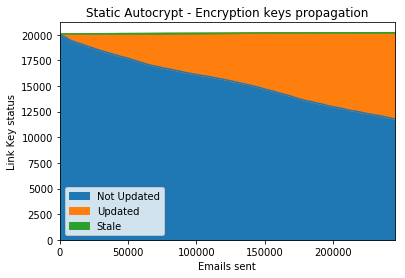

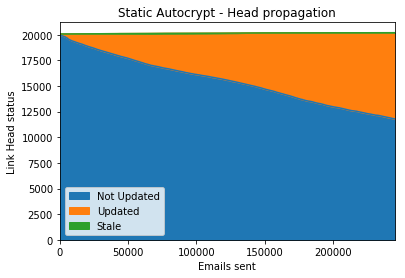

In [11]:
'''Simulate the static view of Autocrypt

* Public and private recipients learn of the sender's latest head
'''
print("Simulating the static view scenario of Autocrypt:")

userset, local_dict, _, _ = prep_static_view(social_graph)

sent_userset_emails = 0
enc_userset_emails = 0

cnt = 0
kp = pd.DataFrame(columns=('Not Updated', 'Updated', 'Stale'))
hp = pd.DataFrame(columns=('Not Updated', 'Updated', 'Stale'))

for index, email in enumerate(log):
    recipients = email.To | email.Cc | email.Bcc - {email.From}
    
    e_status, sent_userset_emails, enc_userset_emails = update_enc_email_status_cnt(email.From, userset, recipients, local_dict, sent_userset_emails, enc_userset_emails)
    email_status["stat_autocrypt"].append(e_status)
    
    # For all recipients, update their local dict entry for the sender
    for recipient in recipients:
        local_dict[(recipient, email.From)] = list(local_dict[email.From, email.From])
    
    if cnt % 100 == 0:
        updated, stale, not_updated = eval_propagation(local_dict, 1, social_graph, userset)
        kp.loc[cnt] = [not_updated, updated, stale]
        updated, stale, not_updated = eval_propagation(local_dict, 0, social_graph, userset)
        hp.loc[cnt] = [not_updated, updated, stale]

    cnt += 1

updated, stale, not_updated = eval_propagation(local_dict, 1, social_graph, userset)
print("Userset users know of %s updates of their friends, %s entries were stale and %s entries were not updated."
      % (updated, stale, not_updated))
print("%s out of the %s emails sent by users in the userset were encrypted." % (enc_userset_emails, sent_userset_emails))

kp.plot.area();
plt.title("Static Autocrypt - Encryption keys propagation")
plt.xlabel("Emails sent")
plt.ylabel("Link Key status")

hp.plot.area();
plt.title("Static Autocrypt - Head propagation")
plt.xlabel("Emails sent")
plt.ylabel("Link Head status")

plt.show()

Simulating the static view scenario of ClaimChain with public claims:
Userset users know of 12007 updates of their friends, while 8185 entries were not updated.
58671 out of the 95615 emails sent by users in the userset were encrypted.


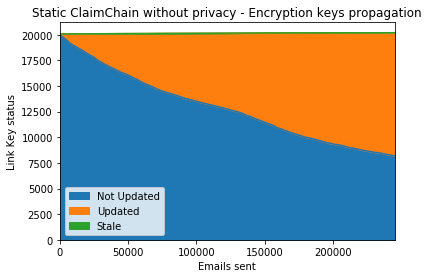

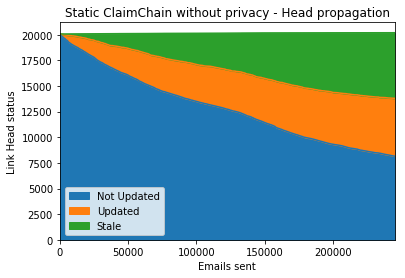

In [12]:
'''Simulate the static view of ClaimChain without privacy (providers mode)

* Public and private recipients learn of the sender's latest head
* Public and private recipients learn of the latest head of the friends of the sender
'''
print("Simulating the static view scenario of ClaimChain with public claims:")

userset, local_dict, public_dict, claim_buffer = prep_static_view(social_graph)
global_graph, _ = make_global_graph(log)

sent_userset_emails = 0
enc_userset_emails = 0

cnt = 0
kp = pd.DataFrame(columns=('Not Updated', 'Updated', 'Stale'))
hp = pd.DataFrame(columns=('Not Updated', 'Updated', 'Stale'))

for email in log:
    recipients = email.To | email.Cc | email.Bcc - {email.From}
    
    e_status, sent_userset_emails, enc_userset_emails = update_enc_email_status_cnt(email.From, userset, recipients, local_dict, sent_userset_emails, enc_userset_emails)
    email_status["stat_pub_claimchain"].append(e_status)
    
    append_block_policy(claim_buffer, email.From, local_dict, public_dict)
    
    # For all recipients, update their local dict entry for the sender
    for recipient in recipients:
        if recipient not in claim_buffer:
            continue
        if ( (recipient, email.From) not in local_dict or
             local_dict[(recipient, email.From)][0] < public_dict[email.From, email.From][0]):
            local_dict[(recipient, email.From)] = list(public_dict[email.From, email.From])
            claim_buffer[recipient][email.From] = list(public_dict[email.From, email.From])
    
    # Update the social graph entries of the recipients for their friends, if the sender
    # knows of a later head
    for recipient in recipients:
        if recipient in global_graph:
            for friend in global_graph[recipient]['friends']:
                if ( (email.From, friend) in public_dict and ( (recipient, friend) not in local_dict or 
                    local_dict[(recipient, friend)][0] < public_dict[(email.From, friend)][0])):
                    local_dict[(recipient, friend)] = list(public_dict[(email.From, friend)])
                    claim_buffer[recipient][email.From] = list(public_dict[email.From, friend])
                    
    if cnt % 100 == 0:
        updated, stale, not_updated = eval_propagation(local_dict, 1, social_graph, userset)
        kp.loc[cnt] = [not_updated, updated, stale]
        updated, stale, not_updated = eval_propagation(local_dict, 0, social_graph, userset)
        hp.loc[cnt] = [not_updated, updated, stale]

    cnt += 1
        

updated, stale, not_updated = eval_propagation(local_dict, 1, social_graph, userset)
print("Userset users know of %s updates of their friends, %s entries were stale and %s entries were not updated."
      % (updated, stale, not_updated))
print("%s out of the %s emails sent by users in the userset were encrypted." % (enc_userset_emails, sent_userset_emails))

kp.plot.area();
plt.title("Static ClaimChain without privacy - Encryption keys propagation")
plt.xlabel("Emails sent")
plt.ylabel("Link Key status")

hp.plot.area();
plt.title("Static ClaimChain without privacy - Head propagation")
plt.xlabel("Emails sent")
plt.ylabel("Link Head status")

plt.show()

Simulating the static view scenario of ClaimChain with private claims and introductions:
Userset users know of 8685 updates of their friends, while 11561 entries were not updated.
51108 out of the 95615 emails sent by users in the userset were encrypted.


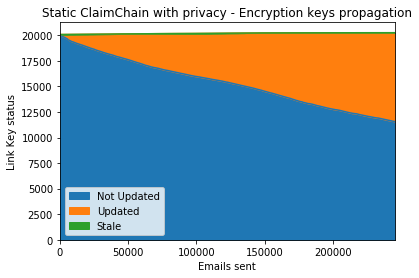

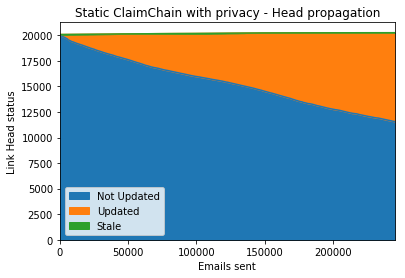

In [13]:
'''Simulate the static view of ClaimChain with support for private claims (introduction mode)

* Public and private recipients learn of the sender's latest head
* Sender grants access to public and private recipients to read the entries of public recipients in her ClaimChain
* Recipients learn of the latest head of the friends of the sender that have the capability to access
'''
print("Simulating the static view scenario of ClaimChain with private claims and introductions:")

userset, local_dict, public_dict, claim_buffer = prep_static_view(social_graph)
introductions = {}

enc_userset_emails = 0
sent_userset_emails = 0

cnt = 0
kp = pd.DataFrame(columns=('Not Updated', 'Updated', 'Stale'))
hp = pd.DataFrame(columns=('Not Updated', 'Updated', 'Stale'))

for index, email in enumerate(log):
    public_recipients = email.To | email.Cc - {email.From}
    recipients = public_recipients | email.Bcc - {email.From}
    
    e_status, sent_userset_emails, enc_userset_emails = update_enc_email_status_cnt(email.From, userset, recipients, local_dict, sent_userset_emails, enc_userset_emails)
    email_status["stat_priv_claimchain"].append(e_status)
    
    append_block_policy(claim_buffer, email.From, local_dict, public_dict)         
    
    # For all recipients, update their local dict entry for the sender
    for recipient in recipients:
        if recipient not in claim_buffer:
            continue
        if ( (recipient, email.From) not in local_dict or
             local_dict[(recipient, email.From)][0] < public_dict[email.From, email.From][0]):
            local_dict[(recipient, email.From)] = list(public_dict[email.From, email.From])
            claim_buffer[recipient][email.From] = list(public_dict[email.From, email.From])

    # Update introductions
    if email.From not in introductions:
        introductions[email.From] = {}

    for recipient in recipients:
        if recipient not in introductions[email.From]:
                introductions[email.From][recipient] = set([])
        for public_recipient in public_recipients:
            introductions[email.From][recipient].add(public_recipient)   
    
    # Update the social graph entries of the recipients for their friends, if the sender
    # knows of a later head and they have access to it
    for recipient in recipients:
        if recipient not in claim_buffer:
            continue
        if recipient in introductions[email.From]:
            for friend in introductions[email.From][recipient]:
                if ((email.From, friend) in public_dict and (
                    (recipient, friend) not in local_dict or local_dict[(recipient, friend)][0] < public_dict[(email.From, friend)][0])):
                    local_dict[(recipient, friend)] = list(public_dict[(email.From, friend)])
                    claim_buffer[recipient][friend] = list(public_dict[(email.From, friend)])
    
    if cnt % 100 == 0:
        updated, stale, not_updated = eval_propagation(local_dict, 1, social_graph, userset)
        kp.loc[cnt] = [not_updated, updated, stale]
        updated, stale, not_updated = eval_propagation(local_dict, 0, social_graph, userset)
        hp.loc[cnt] = [not_updated, updated, stale]

    cnt += 1
        

updated, stale, not_updated = eval_propagation(local_dict, 1, social_graph, userset)
print("Userset users know of %s updates of their friends, %s entries were stale and %s entries were not updated."
      % (updated, stale, not_updated))
print("%s out of the %s emails sent by users in the userset were encrypted." % (enc_userset_emails, sent_userset_emails))

kp.plot.area();
plt.title("Static ClaimChain with privacy - Encryption keys propagation")
plt.xlabel("Emails sent")
plt.ylabel("Link Key status")

kp.plot.area();
plt.title("Static ClaimChain with privacy - Head propagation")
plt.xlabel("Emails sent")
plt.ylabel("Link Head status")

plt.show()

Simulating the dynamic view scenario of Autocrypt:
Userset users know of 6759 updates of their friends, 1684 entries were stale and 11749 entries were not updated.
50208 out of the 95615 emails sent by users in the userset were encrypted.


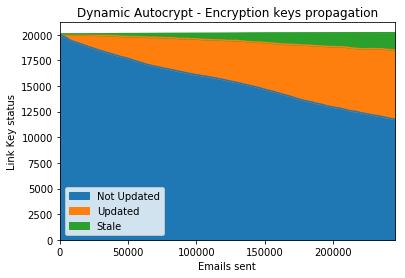

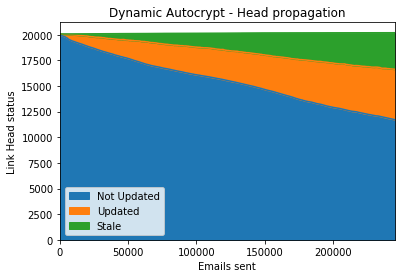

In [19]:
'''Simulate the dynamic view of Autocrypt

* Public and private recipients learn of the sender's latest head
'''
print("Simulating the dynamic view scenario of Autocrypt:")

userset, local_dict, public_dict, claim_buffer = prep_static_view(social_graph)

sent_userset_emails = 0
enc_userset_emails = 0

cnt = 0
kp = pd.DataFrame(columns=('Not Updated', 'Updated', 'Stale'))
hp = pd.DataFrame(columns=('Not Updated', 'Updated', 'Stale'))

cnt_sent_from = {}

for index, email in enumerate(log):
    recipients = email.To | email.Cc | email.Bcc - {email.From}
    
    if email.From not in cnt_sent_from:
        cnt_sent_from[email.From] = 0
    cnt_sent_from[email.From] += 1
    
    if cnt_sent_from[email.From] % 50 == 0:
        local_dict[(email.From, email.From)][1] += 1
        claim_buffer[email.From][email.From] = list(local_dict[(email.From, email.From)])
        append_block_policy(claim_buffer, email.From, local_dict, public_dict, force=True) 

    e_status, sent_userset_emails, enc_userset_emails = update_enc_email_status_cnt(email.From, userset, recipients, local_dict, sent_userset_emails, enc_userset_emails)
    email_status["dyn_autocrypt"].append(e_status)
    
    append_block_policy(claim_buffer, email.From, local_dict, public_dict)  
    
    # For all recipients, update their local dict entry for the sender
    for recipient in recipients:
        if recipient not in claim_buffer:
            continue
        if ( (recipient, email.From) not in local_dict or
             local_dict[(recipient, email.From)][0] < public_dict[email.From, email.From][0]):
            local_dict[(recipient, email.From)] = list(public_dict[email.From, email.From])
            claim_buffer[recipient][email.From] = list(public_dict[email.From, email.From])
    
    if cnt % 100 == 0:
        updated, stale, not_updated = eval_propagation(local_dict, 1, social_graph, userset)
        kp.loc[cnt] = [not_updated, updated, stale]
        updated, stale, not_updated = eval_propagation(local_dict, 0, social_graph, userset)
        hp.loc[cnt] = [not_updated, updated, stale]

    cnt += 1

    
updated, stale, not_updated = eval_propagation(local_dict, 1, social_graph, userset)
print("Userset users know of %s updates of their friends, %s entries were stale and %s entries were not updated."
      % (updated, stale, not_updated))
print("%s out of the %s emails sent by users in the userset were encrypted." % (enc_userset_emails, sent_userset_emails))

kp.plot.area();
plt.title("Dynamic Autocrypt - Encryption keys propagation")
plt.xlabel("Emails sent")
plt.ylabel("Link Key status")

hp.plot.area();
plt.title("Dynamic Autocrypt - Head propagation")
plt.xlabel("Emails sent")
plt.ylabel("Link Head status")

plt.show()

Simulating the dynamic view scenario of ClaimChain with public claims:
Userset users know of 12015 updates of their friends, while 8177 entries were not updated.
58695 out of the 95615 emails sent by users in the userset were encrypted.


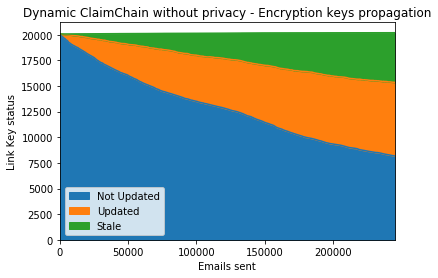

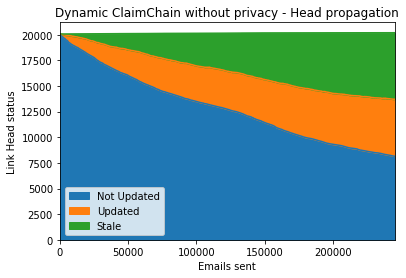

In [16]:
'''Simulate the dynamic view of ClaimChain without privacy (providers mode)

* Public and private recipients learn of the sender's latest head
* Public and private recipients learn of the latest head of the friends of the sender
'''
print("Simulating the dynamic view scenario of ClaimChain with public claims:")

userset, local_dict, public_dict, claim_buffer = prep_static_view(social_graph)
global_graph, global_userset = make_global_graph(log)

sent_userset_emails = 0
enc_userset_emails = 0

cnt = 0
kp = pd.DataFrame(columns=('Not Updated', 'Updated', 'Stale'))
hp = pd.DataFrame(columns=('Not Updated', 'Updated', 'Stale'))

cnt_sent_from = {}

for index, email in enumerate(log):
    recipients = email.To | email.Cc | email.Bcc - {email.From}
    
    if email.From not in cnt_sent_from:
        cnt_sent_from[email.From] = 0
    cnt_sent_from[email.From] += 1
    
    if cnt_sent_from[email.From] % 50 == 0:
        local_dict[(email.From, email.From)][1] += 1
        claim_buffer[email.From][email.From] = list(local_dict[(email.From, email.From)])
        append_block_policy(claim_buffer, email.From, local_dict, public_dict, force=True) 

    e_status, sent_userset_emails, enc_userset_emails = update_enc_email_status_cnt(email.From, userset, recipients, local_dict, sent_userset_emails, enc_userset_emails)
    email_status["dyn_pub_claimchain"].append(e_status)
    
    append_block_policy(claim_buffer, email.From, local_dict, public_dict) 
    
    # For all recipients, update their local dict entry for the sender
    for recipient in recipients:
        if recipient not in claim_buffer:
            continue
        if ( (recipient, email.From) not in local_dict or
             local_dict[(recipient, email.From)][0] < public_dict[email.From, email.From][0]):
            local_dict[(recipient, email.From)] = list(public_dict[email.From, email.From])
            claim_buffer[recipient][email.From] = list(public_dict[email.From, email.From])
    
    # Update the social graph entries of the recipients for their friends, if the sender
    # knows of a later head
    for recipient in recipients:
        if recipient in global_graph:
            for friend in global_graph[recipient]['friends']:
                if ( (email.From, friend) in public_dict and ( (recipient, friend) not in local_dict or 
                    local_dict[(recipient, friend)][0] < public_dict[(email.From, friend)][0])):
                        local_dict[(recipient, friend)] = list(public_dict[(email.From, friend)])
                        claim_buffer[recipient][email.From] = list(public_dict[email.From, friend])

    if cnt % 100 == 0:
        updated, stale, not_updated = eval_propagation(local_dict, 1, social_graph, userset)
        kp.loc[cnt] = [not_updated, updated, stale]
        updated, stale, not_updated = eval_propagation(local_dict, 0, social_graph, userset)
        hp.loc[cnt] = [not_updated, updated, stale]

    cnt += 1
        

updated, stale, not_updated = eval_propagation(local_dict, 1, social_graph, userset)
print("Userset users know of %s updates of their friends, %s entries were stale and %s entries were not updated."
      % (updated, stale, not_updated))
print("%s out of the %s emails sent by users in the userset were encrypted." % (enc_userset_emails, sent_userset_emails))

kp.plot.area();
plt.title("Dynamic ClaimChain without privacy - Encryption keys propagation")
plt.xlabel("Emails sent")
plt.ylabel("Link Key status")

hp.plot.area();
plt.title("Dynamic ClaimChain without privacy - Head propagation")
plt.xlabel("Emails sent")
plt.ylabel("Link Head status")

plt.show()

Simulating the dynamic view scenario of ClaimChain with private claims and introductions:
Userset users know of 7055 updates of their friends, 1668 entries were stale and 11523 entries were not updated.
51483 out of the 95615 emails sent by users in the userset were encrypted.


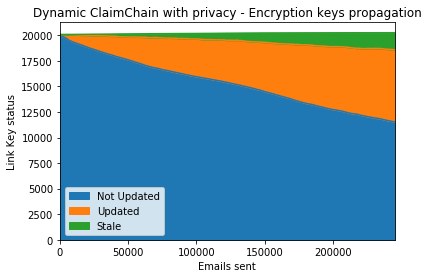

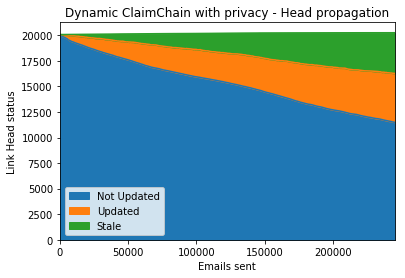

In [17]:
'''Simulate the dynamic view of ClaimChain with support for private claims (introduction mode)

* Public and private recipients learn of the sender's latest head
* Sender grants access to public and private recipients to read the entries of public recipients in her ClaimChain
* Recipients learn of the latest head of the friends of the sender that have the capability to access
'''
print("Simulating the dynamic view scenario of ClaimChain with private claims and introductions:")

userset, local_dict, public_dict, claim_buffer = prep_static_view(social_graph)
introductions = {}

enc_userset_emails = 0
sent_userset_emails = 0

cnt = 0
kp = pd.DataFrame(columns=('Not Updated', 'Updated', 'Stale'))
hp = pd.DataFrame(columns=('Not Updated', 'Updated', 'Stale'))

cnt_sent_from = {}

for index, email in enumerate(log):
    public_recipients = email.To | email.Cc - {email.From}
    recipients = public_recipients | email.Bcc - {email.From}

    if email.From not in cnt_sent_from:
        cnt_sent_from[email.From] = 0
    cnt_sent_from[email.From] += 1
    
    if cnt_sent_from[email.From] % 50 == 0:
        local_dict[(email.From, email.From)][1] += 1
        claim_buffer[email.From][email.From] = list(local_dict[(email.From, email.From)])
        append_block_policy(claim_buffer, email.From, local_dict, public_dict, force=True) 

    e_status, sent_userset_emails, enc_userset_emails = update_enc_email_status_cnt(email.From, userset, recipients, local_dict, sent_userset_emails, enc_userset_emails)
    email_status["dyn_priv_claimchain"].append(e_status)

    append_block_policy(claim_buffer, email.From, local_dict, public_dict) 

    # Update introductions
    if email.From not in introductions:
        introductions[email.From] = {}

    for recipient in recipients:
        if recipient not in introductions[email.From]:
                introductions[email.From][recipient] = set([])
        for public_recipient in public_recipients:
            introductions[email.From][recipient].add(public_recipient)            
    
    # For all recipients, update their local dict entry for the sender
    for recipient in recipients:
        if recipient not in claim_buffer:
            continue
        if ( (recipient, email.From) not in local_dict or
             local_dict[(recipient, email.From)][0] < public_dict[email.From, email.From][0]):
            local_dict[(recipient, email.From)] = list(public_dict[email.From, email.From])
            claim_buffer[recipient][email.From] = list(public_dict[email.From, email.From])
    
    # Update the social graph entries of the recipients for their friends, if the sender
    # knows of a later head and they have access to it
    for recipient in recipients:
        if recipient not in claim_buffer:
            continue
        if recipient in introductions[email.From]:
            for friend in introductions[email.From][recipient]:
                if ((email.From, friend) in public_dict and (
                    (recipient, friend) not in local_dict or local_dict[(recipient, friend)][0] < public_dict[(email.From, friend)][0])):
                    local_dict[(recipient, friend)] = list(public_dict[(email.From, friend)])
                    claim_buffer[recipient][friend] = list(public_dict[(email.From, friend)])
    
    if cnt % 100 == 0:
        updated, stale, not_updated = eval_propagation(local_dict, 1, social_graph, userset)
        kp.loc[cnt] = [not_updated, updated, stale]
        updated, stale, not_updated = eval_propagation(local_dict, 0, social_graph, userset)
        hp.loc[cnt] = [not_updated, updated, stale]

    cnt += 1
        

updated, stale, not_updated = eval_propagation(local_dict, 1, social_graph, userset)
print("Userset users know of %s updates of their friends, %s entries were stale and %s entries were not updated."
      % (updated, stale, not_updated))
print("%s out of the %s emails sent by users in the userset were encrypted." % (enc_userset_emails, sent_userset_emails))

kp.plot.area();
plt.title("Dynamic ClaimChain with privacy - Encryption keys propagation")
plt.xlabel("Emails sent")
plt.ylabel("Link Key status")

hp.plot.area();
plt.title("Dynamic ClaimChain with privacy - Head propagation")
plt.xlabel("Emails sent")
plt.ylabel("Link Head status")

plt.show()

In [20]:
pickle.dump(email_status, open(parsed_logs_folder + "email_status.pkl", "wb"))